# 1. Load the Data

In [1]:
#Import the dataset.
import pandas as pd

df = pd.read_csv('PATH')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.rename(columns={'0': 'Opinion'}, inplace=True)
df

,Opinion,Labels
0,Las momias están en muy buen estado de conserv...,0
1,mi grupo quedó negativamente impresionado. Al...,0
2,on grabadas en lo profundo de las mentes de qu...,0
3,s con ganas de vomitar y espantados. Absolutam...,0
4,"do los muertos, los espantos y los entierros.....",0
...,...,...
12177,minada.,4
12178,"Es imperdible, de ahí puedes ver muy bien la c...",4
12179,hace parte de la aventura montarlo porque se ...,4
12180,Queda detrás del Teatro Juárez. Ir allí camina...,4


In [18]:
#Check how the classes are distributed in the dataset.
df['Labels'].value_counts()

4    5977
3    3825
2    1750
1     413
0     217
Name: Labels, dtype: int64

# 2. Get the tf-idf vector for the corpus

In [2]:
import spacy

#Load the Spanish model
nlp = spacy.load("es_dep_news_trf")

In [3]:
#Tokenizes each word using the Spacy tokenizer.
def my_tokenizer(sentence):
    toks = []
    mytokens = nlp(sentence)
    for token in mytokens:
        toks.append(token.text) 
    return toks

In [4]:
#Create the object for obtaining the TF-IDF vector.
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vector = TfidfVectorizer(tokenizer=my_tokenizer, lowercase=False)

In [5]:
#Vectorize the dataset.
X = tfidf_vector.fit_transform(df['Opinion'])

In [6]:
#Check the type of the object that contains the vector created by the TF-IDF.
X

<12182x16377 sparse matrix of type '<class 'numpy.float64'>'
	with 221232 stored elements in Compressed Sparse Row format>

In [7]:
#Map the sparse matrix to a dense vector.
vector_tfidf = X.todense()

In [8]:
#Check the size of the final vector .
vector_tfidf.shape

(12182, 16377)

# 3. BETO embeddings

In [2]:
#Connect to the GPU.
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "7"

In [3]:
import torch
import tensorflow as tf

if torch.cuda.is_available():    

    #Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')

    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-32GB


In [4]:
#Create the tokenizer and the model (BETO in this case).
from transformers import BertModel, BertTokenizer

model = BertModel.from_pretrained('dccuchile/bert-base-spanish-wwm-cased',
                                  output_attentions = False, # Whether the model returns attentions weights
                                  output_hidden_states = False)
model.cuda()

tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
#Tokenize all of the sentences and map the tokens to their word IDs.
opiniones = df['Opinion'].values

input_ids = []
attention_masks = []

for opinion in opiniones:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        opinion,                   #Sentence to encode.
                        add_special_tokens = True, #Add '[CLS]' and '[SEP]'
                        max_length = 128,           #Pad & truncate all sentences.
                        truncation = True,
                        padding='max_length',
                        return_attention_mask = True,  #Construct attention masks.
                        return_tensors = 'pt',     #Return pytorch tensors.
                        verbose = True #Print more information and warnings.
                   )
    
    #Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])
    
    #And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

#Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

In [7]:
#Create a Dataloader for training the model with the tensors created above.
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, SequentialSampler

#Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks)
dataloader = DataLoader(
            dataset,  #The training samples.
            sampler = SequentialSampler(dataset), #Select batches sequentially.
            batch_size = 128 #Trains with this batch size.
        )

In [9]:
#Set the model into training mode.
model.train()

#Training loop. Passes the input ids and the attention masks to the model.
for step, batch in enumerate(dataloader):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        outputs = model(input_ids, 
                       token_type_ids=None, 
                       attention_mask=attention_mask, 
                       return_dict=True)

In [10]:
#Create an object that contains the outputs at the last layer of the trained BETO model.
last_hidden_states = outputs.last_hidden_state

In [23]:
last_hidden_states.size()

torch.Size([22, 128, 768])

In [16]:
#Get the value of the CLS token. 
#This value contains all the sentence at the position 0.
last_hidden_states[0][0][0].item()

0.3220473825931549

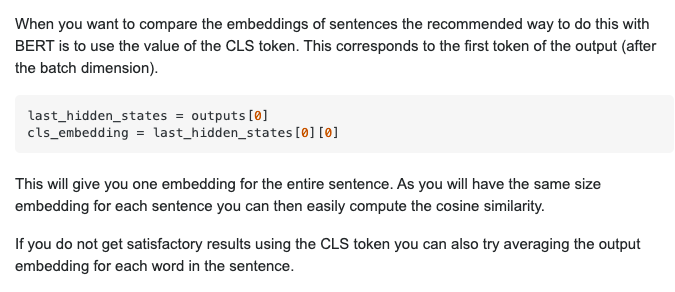

https://stackoverflow.com/questions/63040954/how-to-extract-and-use-bert-encodings-of-sentences-for-text-similarity-among-sen

### Notas:
Mi duda aquí es: una vez ya teniendo un objeto (last_hidden_state) con los valores de cada oración en el dataset, no estoy seguro si ese número es el que debo concatenar a los vectores obtenidos en la sección 1 (vector_tfidf).
Yo me imagino que sí (por esto que encontré y adjunté de StackOverflow --aunque esta no sea una tarea de calcular similitud de coseno, pero sí de obtener word embeddings con BETO), pero no me queda aún 100% claro. 

Tampoco me quedan muy claras las dimensiones de last_hidden_states. Entiendo, por la documentación de huggingface (https://huggingface.co/transformers/model_doc/bert.html#bertmodel) que el 22 es `batch_size` y el 128 es la longitud de la secuencia, pero no me queda muy claro cómo esas dimensiones se corresponden con las (12182, 16377) del `vector_tfidf` (esas sí entiendo que son el número de opiniones --longitud 128-- y los valores numéricos creados para representarlas).

Si sí, entonces ya sólo sería cosa de pegar los outputs de la sección 1 con la sección 2, y pasar eso al BertForSequenceClassification() como lo hice en los experimentos anteriores.